# The Rick and Morty Location API

In [33]:
# Import libraries
import pandas as pd
import requests
import json
import datetime

# S3 imports
import boto3

In [2]:
# Fetch character data from api
url = "https://rickandmortyapi.com/api/location"

response = requests.get(url)
data = response.json()

print(data.keys())

dict_keys(['info', 'results'])


In [3]:
# Analyze the info key
data['info']

{'count': 126,
 'pages': 7,
 'next': 'https://rickandmortyapi.com/api/location?page=2',
 'prev': None}

In [4]:
# Analyze the result key
print(len(data['results']))
data['results'][0]

20


{'id': 1,
 'name': 'Earth (C-137)',
 'type': 'Planet',
 'dimension': 'Dimension C-137',
 'residents': ['https://rickandmortyapi.com/api/character/38',
  'https://rickandmortyapi.com/api/character/45',
  'https://rickandmortyapi.com/api/character/71',
  'https://rickandmortyapi.com/api/character/82',
  'https://rickandmortyapi.com/api/character/83',
  'https://rickandmortyapi.com/api/character/92',
  'https://rickandmortyapi.com/api/character/112',
  'https://rickandmortyapi.com/api/character/114',
  'https://rickandmortyapi.com/api/character/116',
  'https://rickandmortyapi.com/api/character/117',
  'https://rickandmortyapi.com/api/character/120',
  'https://rickandmortyapi.com/api/character/127',
  'https://rickandmortyapi.com/api/character/155',
  'https://rickandmortyapi.com/api/character/169',
  'https://rickandmortyapi.com/api/character/175',
  'https://rickandmortyapi.com/api/character/179',
  'https://rickandmortyapi.com/api/character/186',
  'https://rickandmortyapi.com/api/cha

In [5]:
# Function to write data to a dataframe
from tqdm import tqdm
import time

all_data = []
page = 1

# Initialize the progress bar
with tqdm(desc="Extracting Pages", ncols=100, ascii=True) as pbar:
    while True:
        # Update the progress bar description with the current page
        pbar.set_description(f"Extracting Page {page}")
        
        # Make the API request
        response = requests.get(f'https://rickandmortyapi.com/api/location?page={str(page)}')
        data = response.json().get('results', [])
        
        # Collect data
        all_data.extend(data)
        
        # Update the progress bar (increment by 1 page)
        pbar.update(1)
        
        # Check if there is a next page
        if response.json().get('info', {}).get('next') is not None:
            page += 1
        else:
            break

    print('Data successfully extracted!')

Extracting Page 7: : 7it [00:04,  1.71it/s]

Data succedssfully extracted!


In [19]:
# Load data to dataframe
location_df = pd.DataFrame(all_data)

# Shape of df
print(location_df.shape)

# Ivestigate the dataframe
location_df.head()

(126, 7)


,id,name,type,dimension,residents,url,created
0,1,Earth (C-137),Planet,Dimension C-137,"[https://rickandmortyapi.com/api/character/38,...",https://rickandmortyapi.com/api/location/1,2017-11-10T12:42:04.162Z
1,2,Abadango,Cluster,unknown,[https://rickandmortyapi.com/api/character/6],https://rickandmortyapi.com/api/location/2,2017-11-10T13:06:38.182Z
2,3,Citadel of Ricks,Space station,unknown,"[https://rickandmortyapi.com/api/character/8, ...",https://rickandmortyapi.com/api/location/3,2017-11-10T13:08:13.191Z
3,4,Worldender's lair,Planet,unknown,"[https://rickandmortyapi.com/api/character/10,...",https://rickandmortyapi.com/api/location/4,2017-11-10T13:08:20.569Z
4,5,Anatomy Park,Microverse,Dimension C-137,"[https://rickandmortyapi.com/api/character/12,...",https://rickandmortyapi.com/api/location/5,2017-11-10T13:08:46.060Z


## Data Cleaning

In [20]:
# Clean the origin column
import re

# Function to extract the last digit (resident id) from each URL
def extract_resident_numbers(resident_list):
    if resident_list:
        return [re.search(r'/(\d+)$', url).group(1) for url in resident_list if re.search(r'/(\d+)$', url)]
    return []

# Apply the function to the episodes column
location_df['residents_ids'] = location_df['residents'].apply(extract_resident_numbers)
location_df['total_residents'] = location_df['residents_ids'].apply(len)

# Drop origin and location columns
location_df = location_df.drop('residents', axis=1)

location_df.head()

,id,name,type,dimension,url,created,residents_ids,total_residents
0,1,Earth (C-137),Planet,Dimension C-137,https://rickandmortyapi.com/api/location/1,2017-11-10T12:42:04.162Z,"[38, 45, 71, 82, 83, 92, 112, 114, 116, 117, 1...",27
1,2,Abadango,Cluster,unknown,https://rickandmortyapi.com/api/location/2,2017-11-10T13:06:38.182Z,[6],1
2,3,Citadel of Ricks,Space station,unknown,https://rickandmortyapi.com/api/location/3,2017-11-10T13:08:13.191Z,"[8, 14, 15, 18, 21, 22, 27, 42, 43, 44, 48, 53...",101
3,4,Worldender's lair,Planet,unknown,https://rickandmortyapi.com/api/location/4,2017-11-10T13:08:20.569Z,"[10, 81, 208, 226, 340, 362, 375, 382, 395]",9
4,5,Anatomy Park,Microverse,Dimension C-137,https://rickandmortyapi.com/api/location/5,2017-11-10T13:08:46.060Z,"[12, 17, 96, 97, 98, 99, 100, 101, 108, 268, 300]",11


In [21]:
# Reorder columns
location_df = location_df[location_df.columns[[0, 1, 2, 3, 6, 7, 5, 4]]]

location_df.head()

,id,name,type,dimension,residents_ids,total_residents,created,url
0,1,Earth (C-137),Planet,Dimension C-137,"[38, 45, 71, 82, 83, 92, 112, 114, 116, 117, 1...",27,2017-11-10T12:42:04.162Z,https://rickandmortyapi.com/api/location/1
1,2,Abadango,Cluster,unknown,[6],1,2017-11-10T13:06:38.182Z,https://rickandmortyapi.com/api/location/2
2,3,Citadel of Ricks,Space station,unknown,"[8, 14, 15, 18, 21, 22, 27, 42, 43, 44, 48, 53...",101,2017-11-10T13:08:13.191Z,https://rickandmortyapi.com/api/location/3
3,4,Worldender's lair,Planet,unknown,"[10, 81, 208, 226, 340, 362, 375, 382, 395]",9,2017-11-10T13:08:20.569Z,https://rickandmortyapi.com/api/location/4
4,5,Anatomy Park,Microverse,Dimension C-137,"[12, 17, 96, 97, 98, 99, 100, 101, 108, 268, 300]",11,2017-11-10T13:08:46.060Z,https://rickandmortyapi.com/api/location/5


## EDA - Exploratory Data Analysis

In [24]:
# import visulaization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [29]:
# Location type value count
type_of_loc = location_df['type'].value_counts().head(4)
type_of_loc

Planet           62
Space station     7
Dimension         4
Microverse        3
Name: type, dtype: int64

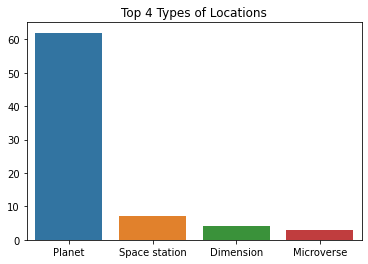

In [32]:
# Plot a bar plot showing the status
ax = sns.barplot(x=type_of_loc.index, y=type_of_loc.values)

# Set the xtick labels
ax.set_xticklabels(type_of_loc.index)
ax.set_title('Top 4 Types of Locations');

### Top 10 charcater episode appearances

In [28]:
# Sort the DataFrame by 'total_episodes' in descending order
sorted_df = location_df.sort_values(by='total_residents', ascending=False)

# Select the top 10 characters
top_10_locations = sorted_df.head(10)

# Display the result
top_10_locations[['name', 'total_residents']]


,name,total_residents
19,Earth (Replacement Dimension),230
2,Citadel of Ricks,101
5,Interdimensional Cable,62
0,Earth (C-137),27
95,Story Train,27
77,Snake Planet,15
12,Nuptia 4,11
109,Narnia Dimension,11
34,Planet Squanch,11
125,Rick's Memories,11


In [36]:
import os
from io import StringIO

#Creating Session With Boto3.
session = boto3.Session(
aws_access_key_id=os.getenv('aws_access_key_id'),
aws_secret_access_key=os.getenv('aws_secret_access_key')
)

# Convert DataFrame to CSV string
csv_buffer = StringIO()
location_df.to_csv(csv_buffer, index=False)

# Get current timestamp
timestamp = datetime.datetime.now()

year = str(timestamp.year)
month = str(timestamp.month).zfill(2)
day = str(timestamp.day).zfill(2)
hour = str(timestamp.hour).zfill(2)
minute = str(timestamp.minute).zfill(2)

#Creating S3 Resource From the Session.
s3 = session.resource('s3')

# Write data to s3
result = s3.meta.client.put_object(Body=csv_buffer.getvalue(), 
                                   Bucket='rick-and-morty-de',
                                   Key=f'rick_and_morty/Location/{year}/{month}/{day}/{hour}/{minute}/location.csv')

res = result.get('ResponseMetadata')

if res.get('HTTPStatusCode') == 200:
    print('File Uploaded Succesfully')
else:
    print('File Not Uploaded')

File Uploaded Succesfully
